# Statistical Analysis 

Analyzing the significance of the differences between the modified Still Face Paradigm conditions.

In [75]:
import json 
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from hypyp import stats 
import seaborn as sns
from statannot import add_stat_annotation
import scikit_posthocs as sp
import pandas as pd

# Infant Alpha band (6-9 Hz) analysis

In [76]:
f = open('results_alpha_plv1.json')

# returns JSON object as 
# a dictionary
results = json.load(f)
  
# Iterating through the json
# list
fp1_alpha = []
sf1_alpha = []
fp2_alpha = []
sf2_alpha = []
ru_alpha = []

all_stages = [fp1_alpha, sf1_alpha, fp2_alpha, sf2_alpha, ru_alpha]
for part, stages in results.items():
    if part == '623' or part == '802':
        continue
    else:
        for stage, data in stages.items():
            stage = int(stage[1]) - 1
            all_stages[stage].append(np.nanmean(data))

sf2_alpha = [0 if str(x) == 'nan' else x for x in sf2_alpha]

data_alpha = [np.array(fp1_alpha), np.array(sf1_alpha), np.array(fp2_alpha), np.array(sf2_alpha)] 

### Descriptive analysis

In [77]:
descriptives = {'Mean': [],
                'SD': [],
                'Min': [],
                'Max': []}

for condition in all_stages: 
    descriptives['Mean'].append(round(np.mean(condition), 4))
    descriptives['SD'].append(round(np.std(condition), 4))
    descriptives['Min'].append(round(np.min(condition), 4))
    descriptives['Max'].append(round(np.max(condition), 4))

descriptives_df = pd.DataFrame(descriptives)
descriptives_df.insert(0, 'Condition', ['Free Play 1', 'Still Face 1', 'Free Play 2',
                                        'Still Face 2', 'Reunion'])

descriptives_df.to_latex('synchrony_descriptives_alpha.tex')
descriptives_df

/tmp/ipykernel_5858/1220507243.py:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  descriptives_df.to_latex('synchrony_descriptives_alpha.tex')


,Condition,Mean,SD,Min,Max
0,Free Play 1,0.4901,0.0165,0.4583,0.5302
1,Still Face 1,0.4841,0.0188,0.4333,0.5419
2,Free Play 2,0.4875,0.0197,0.4613,0.5565
3,Still Face 2,0.4863,0.0215,0.4388,0.5399
4,Reunion,0.4882,0.0164,0.4588,0.5356


# Test Normality of Distribution

In [78]:
import pandas as pd
import pingouin as pg
from scipy.stats import shapiro

# Load data
df = pd.DataFrame({"FreePlay1": fp1_alpha,
                  "StillFace1": sf1_alpha,
                  "FreePlay2": fp2_alpha,
                  "StillFace2": sf2_alpha,
                  'Reunion': ru_alpha
                  })


# Create a multi-indexed dataframe
df_melted_alpha = pd.melt(df.reset_index(), id_vars=['index'], value_vars=['FreePlay1', 'StillFace1', 'FreePlay2', 'StillFace2', 'Reunion'])

# Rename columns
df_melted_alpha.columns = ['id', 'Condition', 'Synchrony']

# grouped = df_melted.groupby(["condition"])

data = np.random.normal(0, 1, 100)
stat, p = shapiro(df_melted_alpha["Synchrony"])

print("Test statistic:", stat)
if p > 0.05:
    print("p = ", p, "-> data is normally distributed")
else:
    print("p-value = ", p, "-> data is non-normally distributed")

Test statistic: 0.9631109237670898
p-value =  0.00022770768555346876 -> data is non-normally distributed


# Fisher Z Transform

In [79]:
# Perform the Fisher z-transform
z_fp1_alpha = np.arctanh(fp1_alpha)
z_sf1_alpha = np.arctanh(sf1_alpha)
z_fp2_alpha = np.arctanh(fp2_alpha)
z_sf2_alpha = np.arctanh(sf2_alpha)
z_ru_alpha = np.arctanh(ru_alpha)

# Load data
df = pd.DataFrame({"FreePlay1": z_fp1_alpha,
                  "StillFace1": z_sf1_alpha,
                  "FreePlay2": z_fp2_alpha,
                  "StillFace2": z_sf2_alpha,
                  'Reunion': z_ru_alpha
                  })


# Create a multi-indexed dataframe
df_melted_z = pd.melt(df.reset_index(), id_vars=['index'], value_vars=['FreePlay1', 'StillFace1', 'FreePlay2', 'StillFace2', 'Reunion'])

# Rename columns
df_melted_z.columns = ['id', 'Condition', 'Synchrony']

data = np.random.normal(0, 1, 100)
stat, p = shapiro(df_melted_z["Synchrony"])

print("Test statistic:", stat)
if p > 0.05:
    print("p = ", p, "-> data is normally distributed")
else:
    print("p-value = ", p, "-> data is non-normally distributed")

Test statistic: 0.956810474395752
p-value =  5.555658935918473e-05 -> data is non-normally distributed


### The distribution is still not normal -> non-parametric one-way ANOVA -> Friedman Test

## Main Effect: Friedman Test
The null hypothesis (H0): The mean for each population is equal.

The alternative hypothesis: (Ha): At least one population mean is different from the rest.

https://www.statology.org/friedman-test-python/

In [80]:
# Perform Friedman test 
pg.friedman(data=df_melted_alpha, dv='Synchrony', within='Condition', subject = 'id', method = 'f')

,Source,W,ddof1,ddof2,F,p-unc
Friedman,Condition,0.024059,3.939394,126.060606,0.78886,0.532774


## Post Hoc Analysis: Wilcoxon Signed-Rank Test 

In [81]:
post_hoc_wilcoxon_alpha = sp.posthoc_wilcoxon(a = df_melted_alpha, val_col = "Synchrony", group_col = "Condition", p_adjust = 'bonferroni')
post_hoc_wilcoxon_alpha

,FreePlay1,StillFace1,FreePlay2,StillFace2,Reunion
FreePlay1,1.000000,0.798486,1.0,1.0,1.0
StillFace1,0.798486,1.000000,1.0,1.0,1.0
FreePlay2,1.000000,1.000000,1.0,1.0,1.0
StillFace2,1.000000,1.000000,1.0,1.0,1.0
Reunion,1.000000,1.000000,1.0,1.0,1.0


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  wilcox
FreePlay1 v.s. StillFace1: Wilcoxon test (paired samples) with Bonferroni correction, P_val=7.985e-01 stat=1.820e+02
Using zero_method  wilcox
StillFace1 v.s. FreePlay2: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.000e+00 stat=2.460e+02
Using zero_method  wilcox
FreePlay2 v.s. StillFace2: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.000e+00 stat=2.700e+02
Using zero_method  wilcox
StillFace2 v.s. Reunion: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.000e+00 stat=2.650e+02
Using zero_method  wilcox
FreePlay1 v.s. FreePlay2: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.000e+00 stat=1.900e+02
Using zero_method  wilcox
FreePlay2 v.s. Reunion: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.000e+00

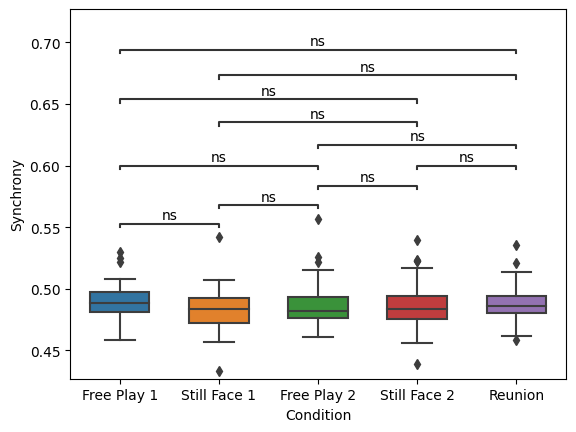

In [102]:
ax = sns.boxplot(data = df_melted_alpha, x = 'Condition', y = 'Synchrony', width = 0.6)
ax.set_xticklabels(['Free Play 1', 'Still Face 1', 'Free Play 2', 'Still Face 2', 'Reunion'])
# ax.set(ylim=(0.3, 0.55))
add_stat_annotation(ax, data = df_melted_alpha, x = 'Condition', y = 'Synchrony', 
                    box_pairs = [('FreePlay1', 'StillFace1'), ('FreePlay1', 'StillFace2'),  ('StillFace1', 'FreePlay2'), ('FreePlay2', 'StillFace2'),
                                 ('StillFace1', 'Reunion'), ('StillFace2', 'Reunion'),
                                 ('FreePlay1', 'FreePlay2'), ('FreePlay1', 'Reunion'), ('FreePlay2', 'Reunion'),
                                 ('StillFace1', 'StillFace2')
                                ],
                    perform_stat_test=True,
                    test = 'Wilcoxon',
                    text_format = 'star',
)

ax.figure.savefig("alpha_results.png") 

# Infant Theta Band (3-5 Hz) Analysis

In [84]:
f = open('results_theta_plv1.json')

# returns JSON object as 
# a dictionary
results = json.load(f)
  
# Iterating through the json
# list
fp1_theta = []
sf1_theta = []
fp2_theta = []
sf2_theta = []
ru_theta = []

all_stages = [fp1_theta, sf1_theta, fp2_theta, sf2_theta, ru_theta]
for part, stages in results.items():
    if part == '802' or part == '623':
        continue
    else:
        for stage, data in stages.items():
            stage = int(stage[1]) - 1
            all_stages[stage].append(np.nanmean(data))

sf2_theta = [0 if str(x) == 'nan' else x for x in sf2_theta]

data_theta = [fp1_theta, sf1_theta, fp2_theta, sf2_theta, ru_theta] 
data_theta = [np.array(x) for x in data_theta]

f.close()

## Descriptive Statistics

In [85]:
descriptives = {'Mean': [],
                'SD': [],
                'Min': [],
                'Max': []}

for condition in all_stages: 
    descriptives['Mean'].append(round(np.mean(condition), 4))
    descriptives['SD'].append(round(np.std(condition), 4))
    descriptives['Min'].append(round(np.min(condition), 4))
    descriptives['Max'].append(round(np.max(condition), 4))

descriptives_df = pd.DataFrame(descriptives)
descriptives_df.insert(0, 'Condition', ['Free Play 1', 'Still Face 1', 'Free Play 2',
                                        'Still Face 2', 'Reunion'])

descriptives_df.to_latex('synchrony_descriptives_theta.tex')
descriptives_df

/tmp/ipykernel_5858/222204992.py:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  descriptives_df.to_latex('synchrony_descriptives_theta.tex')


,Condition,Mean,SD,Min,Max
0,Free Play 1,0.5621,0.0221,0.5169,0.6096
1,Still Face 1,0.5456,0.0192,0.5171,0.6229
2,Free Play 2,0.5556,0.0178,0.5200,0.5960
3,Still Face 2,0.5512,0.0292,0.5024,0.6445
4,Reunion,0.5614,0.0188,0.5222,0.6208


In [86]:
# Load data
df = pd.DataFrame({"FreePlay1": fp1_theta,
                  "StillFace1": sf1_theta,
                  "FreePlay2": fp2_theta,
                  "StillFace2": sf2_theta,
                  'Reunion': ru_theta
                  })


# Create a multi-indexed dataframe
df_melted_theta = pd.melt(df.reset_index(), id_vars=['index'], value_vars=['FreePlay1', 'StillFace1', 'FreePlay2', 'StillFace2', 'Reunion'])

# Rename columns
df_melted_theta.columns = ['id', 'Condition', 'Synchrony']

stat, p = shapiro(df_melted_theta["Synchrony"])

print("Test statistic:", stat)
if p > 0.05:
    print("p = ", p, "-> data is normally distributed")
else:
    print("p-value = ", p, "-> data is non-normally distributed")

Test statistic: 0.9556348323822021
p-value =  4.316076228860766e-05 -> data is non-normally distributed


## Fisher Z-Transform

In [87]:
# Perform the Fisher z-transform
z_fp1_theta = np.arctanh(fp1_theta)
z_sf1_theta = np.arctanh(sf1_theta)
z_fp2_theta = np.arctanh(fp2_theta)
z_sf1_theta = np.arctanh(sf1_theta)
z_ru_theta = np.arctanh(ru_theta)

# Load data
df = pd.DataFrame({"FreePlay1": z_fp1_alpha,
                  "StillFace1": z_sf1_alpha,
                  "FreePlay2": z_fp2_alpha,
                  "StillFace2": z_sf2_alpha,
                  'Reunion': z_ru_alpha
                  })


# Create a multi-indexed dataframe
df_melted_z = pd.melt(df.reset_index(), id_vars=['index'], value_vars=['FreePlay1', 'StillFace1', 'FreePlay2', 'StillFace2', 'Reunion'])

# Rename columns
df_melted_z.columns = ['id', 'Condition', 'Synchrony']

data = np.random.normal(0, 1, 100)
stat, p = shapiro(df_melted_z["Synchrony"])

print("Test statistic:", stat)
if p > 0.05:
    print("p = ", p, "-> data is normally distributed")
else:
    print("p-value = ", p, "-> data is non-normally distributed")

Test statistic: 0.956810474395752
p-value =  5.555658935918473e-05 -> data is non-normally distributed


## Main Effect: Friedman Test

In [88]:
# Perform Friedman test
pg.friedman(data=df_melted_theta, dv='Synchrony', within='Condition', subject = 'id', method = 'f')

,Source,W,ddof1,ddof2,F,p-unc
Friedman,Condition,0.24775,3.939394,126.060606,10.539062,2.488407e-07


## Post Hoc: Wilcoxon Signed-Rank Test

In [89]:
post_hoc_wilcoxon_theta = sp.posthoc_wilcoxon(a = df_melted_theta, val_col = "Synchrony", group_col = "Condition", p_adjust = 'bonferroni')
post_hoc_wilcoxon_theta

,FreePlay1,StillFace1,FreePlay2,StillFace2,Reunion
FreePlay1,1.000000,0.00034,0.933224,0.073891,1.000000
StillFace1,0.000340,1.00000,0.000200,1.000000,0.000200
FreePlay2,0.933224,0.00020,1.000000,0.707899,0.528197
StillFace2,0.073891,1.00000,0.707899,1.000000,0.040233
Reunion,1.000000,0.00020,0.528197,0.040233,1.000000


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  wilcox
FreePlay1 v.s. StillFace1: Wilcoxon test (paired samples) with Bonferroni correction, P_val=3.398e-04 stat=6.400e+01
Using zero_method  wilcox
StillFace1 v.s. FreePlay2: Wilcoxon test (paired samples) with Bonferroni correction, P_val=2.000e-04 stat=5.900e+01
Using zero_method  wilcox
FreePlay2 v.s. StillFace2: Wilcoxon test (paired samples) with Bonferroni correction, P_val=7.079e-01 stat=1.790e+02
Using zero_method  wilcox
StillFace2 v.s. Reunion: Wilcoxon test (paired samples) with Bonferroni correction, P_val=4.023e-02 stat=1.230e+02
Using zero_method  wilcox
FreePlay1 v.s. FreePlay2: Wilcoxon test (paired samples) with Bonferroni correction, P_val=9.332e-01 stat=1.860e+02
Using zero_method  wilcox
FreePlay2 v.s. Reunion: Wilcoxon test (paired samples) with Bonferroni correction, P_val=5.282e-01

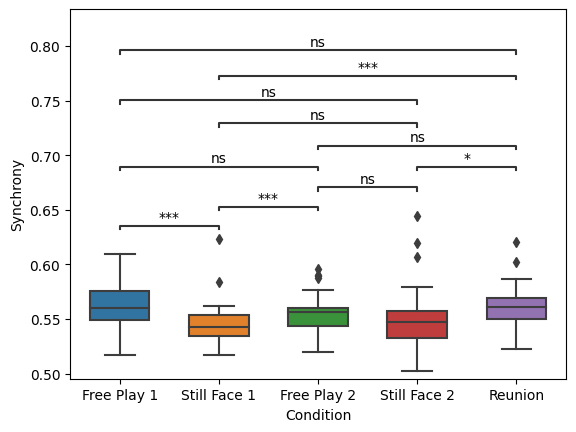

In [101]:
ax = sns.boxplot(data = df_melted_theta, x = 'Condition', y = 'Synchrony', width = 0.6)
ax.set_xticklabels(['Free Play 1', 'Still Face 1', 'Free Play 2', 'Still Face 2', 'Reunion'])
# ax.set(ylim=(0.3, 0.55))
add_stat_annotation(ax, data = df_melted_theta, x = 'Condition', y = 'Synchrony', 
                    box_pairs = [('FreePlay1', 'StillFace1'), ('FreePlay1', 'StillFace2'),  ('StillFace1', 'FreePlay2'), ('FreePlay2', 'StillFace2'),
                                 ('StillFace1', 'Reunion'), ('StillFace2', 'Reunion'),
                                 ('FreePlay1', 'FreePlay2'), ('FreePlay1', 'Reunion'), ('FreePlay2', 'Reunion'),
                                 ('StillFace1', 'StillFace2')
                                 ],
                    perform_stat_test=True,
                    test = 'Wilcoxon',
                    text_format = 'star',
)

ax.figure.savefig("theta_results.png") 

## Calculating the % of the data kept

In [91]:
with open("results_theta_plv1.json") as f:
    results_theta = json.load(f)

# print(np.array(results_theta['029']['-1-']))

# np.count_nonzero(~np.isnan(np.array(results_theta['036']['-1-']))) # 665
epochs = 0
percent_kept = [0, 0, 0, 0, 0]
for part, stages in results_theta.items():
    for stage, data in stages.items():
        stage = int(stage[1]) - 1
        epochs += np.array(data).shape[0]
        nan_count = np.count_nonzero(np.isnan(np.array(data)))
        nonnan_count = np.count_nonzero(~np.isnan(np.array(data)))
        percent_kept[stage - 1] = nonnan_count/(nonnan_count+nan_count)
            
    
print(np.mean(percent_kept))

0.23466435185185186


In [92]:
with open("results_alpha_plv1.json") as f:
    results_theta = json.load(f)

# print(np.array(results_theta['029']['-1-']))

# np.count_nonzero(~np.isnan(np.array(results_theta['036']['-1-']))) # 665
epochs = 0
percent_kept = [0, 0, 0, 0, 0]
for part, stages in results_theta.items():
    for stage, data in stages.items():
        stage = int(stage[1]) - 1
        epochs += np.array(data).shape[0]
        nan_count = np.count_nonzero(np.isnan(np.array(data)))
        nonnan_count = np.count_nonzero(~np.isnan(np.array(data)))
        percent_kept[stage - 1] = nonnan_count/(nonnan_count+nan_count)
            
    
print(np.mean(percent_kept))

0.26915509259259257
